# FACE DETECTION

Author: Nhan TV <br>
Master of Data Science <br>
VNU-HUS

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## HOG Features

1. Tùy trọn hình ảnh chuẩn hóa trước; <br>
2. Kết hợp hình ảnh với hai bộ lọc nhạy với gradient độ sáng ngang và dọc; <br>
3. Chia nhỏ hình ảnh thành các ô có kích thước được xác định trước và tính toán histograms hướng dốc trong mỗi ô;<br>
4. Chuẩn hóa histograms trong mỗi ô bằng cách so sánh với khối các ô lân cận;<br>
5. Xây dựng một vectơ đặc trưng một chiều từ thông tin trong mỗi ô.

C:\Users\admin\Anaconda3\lib\site-packages\skimage\feature\_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


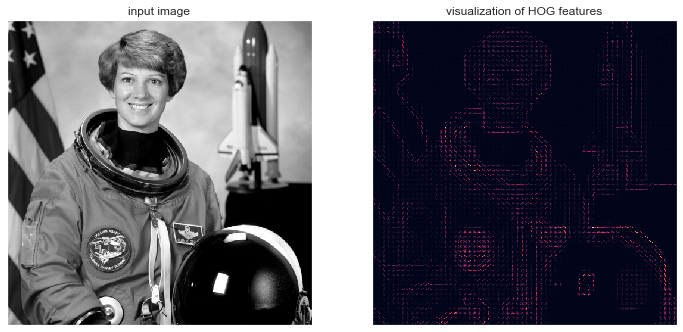

In [62]:
from skimage import data, color, feature
import skimage.data

image = color.rgb2gray(data.astronaut())
hog_vec, hog_vis = feature.hog(image, visualise=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

## A Simple Face Detector

1. Có được một tập hợp các ảnh thumbnail của khuôn mặt để tạo thành các mẫu huấn luyện dương bản;<br>
1. Có được một tập hợp các ảnh thumbnail không phải khuôn mặt để tạo thành các mẫu huấn luyện âm bản;<br>
3. Trích chọn các đặc trưng HOG từ các mẫu huấn luyện này;
4. Huấn luyện một bộ phân loại <b>SVM</b> tuyến tính trên các mẫu này;
5. Đối với hình ảnh "không xác định", chuyển một cửa sổ trượt ngang qua hình ảnh, sử dụng mô hình để đánh giá xem cửa sổ đó có chứa khuôn mặt hay không;
6. Nếu phát hiện trùng lặp, kết hợp chúng vào một cửa sổ duy nhất.

In [175]:
# Obtain a set of positive training samples
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [5]:
# Obtain a set of negative training samples
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]


Có khoảng 30.000 hình ảnh phù hợp không chứa khuôn mặt. Chúng ta hãy xem một vài trong số chúng.

In [6]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

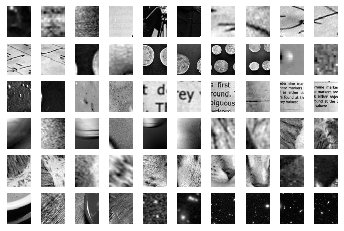

In [7]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

In [8]:
# Combine sets and extract HOG features
from itertools import chain
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [9]:
X_train.shape

(43233, 1215)

In [15]:
from sklearn.naive_bayes import GaussianNB
#from sklearn import cross_validation
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.95385469, 0.97349247, 0.97501908])

In [17]:
# Training a support vector machine
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the numb

0.9891286748548562

In [18]:
grid.best_params_

{'C': 1.0}

In [19]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [170]:
# Find faces in a new image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

test_image=mpimg.imread('D:/Data Science/Data Science Core/Documents/Advanced ML - Do Thanh Ha/practical-face-detection/practical-face-detection/images/img1.jpg')

C:\Users\admin\Anaconda3\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


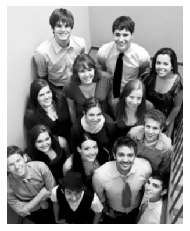

In [171]:
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 1.5)
#test_image = test_image[:160, :]
plt.imshow(test_image, cmap='gray')
plt.axis('off');

In [172]:
"""Create a window that iterates over patches of this image, and compute HOG features for each patch""" 
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(18997, 1215)

In [173]:
"""Take these HOG-featured patches and use our model to evaluate whether each patch contains a face"""
labels = model.predict(patches_hog)
labels.sum()

412.0

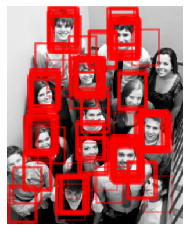

In [174]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))